In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8) # set default figure size, 12in by 10in
sns.set_style("whitegrid")

This week, we will be covering anomaly detection which is widely used in fraud detection (e.g. ‘has this credit card been stolen?’). Given a large number of data points, we may sometimes want to figure out which ones vary significantly from the average. For example, in manufacturing, we may want to detect defects or anomalies. We show how a dataset can be modeled using a Gaussian distribution, and how the model can be used for anomaly detection.

# Video W9 01: Problem Motivation (Anomaly Detection)

[YouTube Video Link](https://www.youtube.com/watch?v=hhI-PdMO1sk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=89)

Imagine you are a a manufacturer and are performing quality control on your manufacturing process. You might
gather data with features like:

- $x_0 = $ heat generated
- $x_1 = $ vibration intensity.

We might have data that looks like this:

Text(4.1, 1.7, 'anomaly')

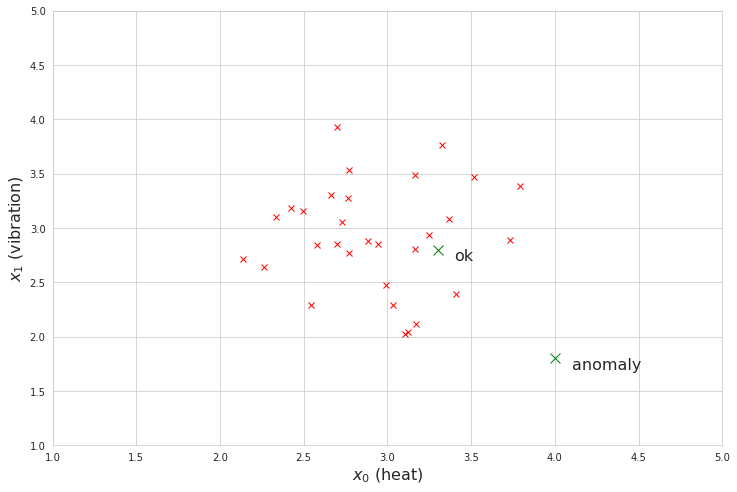

In [3]:
# just make a random dataset example where both features are distributed in a normal distribution
m = 30 # number of samples to generate
mu = 0.0
sigma = 0.5

np.random.seed(42)
X = np.random.normal(mu, sigma, (m, 2)) + 3.0

# plot the ok data
plt.plot(X[:,0], X[:,1], 'rx');
plt.axis([1, 5, 1, 5]);
plt.xlabel('$x_0$ (heat)', fontsize=16);
plt.ylabel('$x_1$ (vibration)', fontsize=16);

# new item x_test
x_test1 = np.array([3.3, 2.8])
plt.plot(x_test1[0], x_test1[1], 'gx', markersize=10)
plt.text(x_test1[0]+0.1, x_test1[1]-0.1, 'ok', fontsize=16)

x_test2 = np.array([4.0, 1.8])
plt.plot(x_test2[0], x_test2[1], 'gx', markersize=10)
plt.text(x_test2[0]+0.1, x_test2[1]-0.1, 'anomaly', fontsize=16)


More formaly, in anomaly detection we are given some dataset: $\{ x^{(1)}, x^{(2)}, \cdots, x^{(m)} \}$

We assume that the given dataset is normal, that it represents usual samples of the dataset.

We want an algorithm that tells us if a new sample $x_{test}$ is "anomalous", where this will mean that
it looks out of the expected range or pattern for the dataset given the nonanomalous data.

In one sense the training set is unlabeled, though you can also think of it as a set of data all labeled
as ok.  

We want to build a model $p(x)$, which is the probability of $x$, where $x$ is the features of the dataset.

\begin{equation}
\begin{cases}
p(x_{test}) < \epsilon \to \text{flag as anomalous}\\
p(x_{test}) \ge \epsilon \to \text{ok}
\end{cases}
\end{equation}

The model $p(x)$ needs to estimate the "density" of the data, so that points in the dense part of the
distribution are assigned a high probability density, and those that are far from other examples are
assigned a low probability.

## Anomaly detection example

- Fraud detection:
  - $x^{(i)} = $ features of user $i$'s activities (how often log in, typing speed, etc.)
  - Model $p(x)$ from data.
  - Identify unusual users by checking which have $p(x) < \epsilon$
  
- Manufacturing
- Monitoring computers in a data center.
  - $x^{(i)} = $ features of machine $i$
  - memory use, number of disk accesses/sec, CPU load, CPU load / network traffic
  


# Video W9 02: Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=2yosK5CJZmo&index=90&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

## Gaussian (Normal) distribution

A review of the gaussian distribution.  Say $x \in \mathbb{R}$ If $x$ is a random variable distributed according
to a Gaussian distribution, with a mean $\mu$ and variance $\sigma^2$ (or equivalently standard deviation $\sigma$,
then the continuous probability density function of the random variable is given by the formula:

\begin{equation}
n(x; \mu, \sigma) = \frac{1}{ \sqrt{2 \pi \sigma} } e^{- \frac{1}{2 \sigma^2} (x - \mu)^2 }
\end{equation}


We normally don't have to know the formula to work with a gaussian distribution.  In Python, it is
best to use the `scipy.stats` classes that are defined to work with standard probability distributions.
The `scipy.stats.norm` class defines the normal or gaussian distribution.

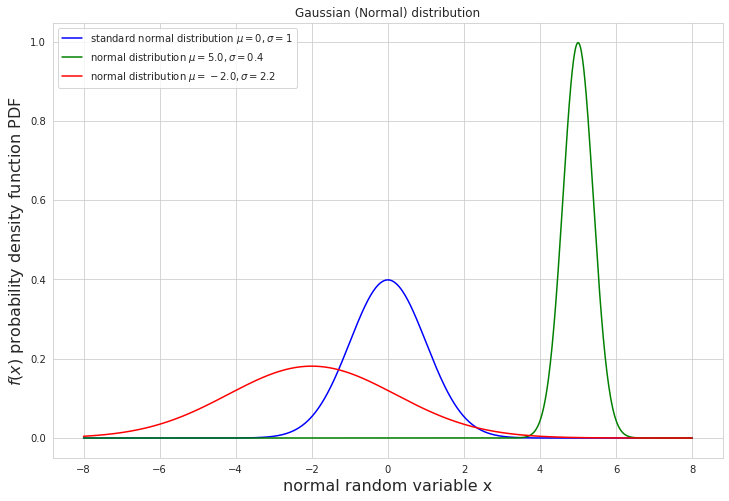

In [4]:
from scipy.stats import norm

# the default when creating a normal distribution from scipy.stats is to create a standard
# normal distribution with mu=0 and sigma=1, so we don't really have to pass in the
# metaparameters here if we want a standard normal distribution, we are given one by default
n_standard = norm()

# create some other normal distributions
mu_1 = 5.0
sigma_1 = 0.4
n_1 = norm(mu_1, sigma_1)

mu_2 = -2.0
sigma_2 = 2.2
n_2 = norm(mu_2, sigma_2)


# plot the standard normal distribution and the other ones for comparison
x = np.linspace(-8.0, 8.0, 1000)
plt.plot(x, n_standard.pdf(x), 'b-', label='standard normal distribution $\mu=0, \sigma=1$')
plt.plot(x, n_1.pdf(x), 'g-', label='normal distribution $\mu=%0.1f, \sigma=%0.1f$' % (mu_1, sigma_1))
plt.plot(x, n_2.pdf(x), 'r-', label='normal distribution $\mu=%0.1f, \sigma=%0.1f$' % (mu_2, sigma_2))
plt.xlabel('normal random variable x', fontsize=16);
plt.ylabel('$f(x)$ probability density function PDF', fontsize=16);
plt.legend();
plt.title('Gaussian (Normal) distribution');

Notice that we use the `.pdf()` function of the `scipy.stats.norm` object to plot the probability density function
of the normal curves.   A standard normal distribution has a mean of 0 and a standard deviation/variance of 1.
Notices that for other normal distributions, the `norm` object takes the mean $\mu$ and the standard deviation
$\sigma$ as meta parameters that define the distributions.  When the standard deviation is small, the
distribution will be skinny and tall.  When the standard deviation is large, the density will be more flat
and spread out.  But in all cases, the are probability density functions, so the area under the curves
all add up to 1.

In [5]:
from scipy.integrate import quad as integrate

integrate(n_standard.pdf, -np.infty, np.infty)

(0.9999999999999998, 1.0178191320905743e-08)

As an aside, we can also draw or generate random samples from a normal distribution. I actually did that above
to create the example data, using the `np.random.normal()` function.  You can also use `scipy.stats.norm`
function to draw a random sample from a normal distribution, using the `.rvs()` function, like this:

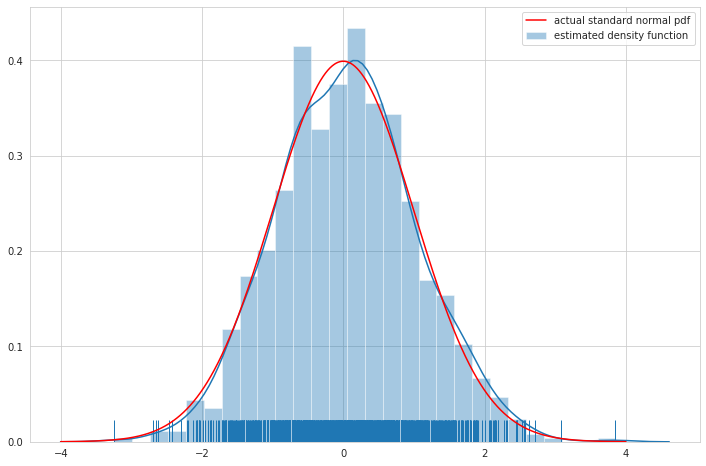

In [6]:
# draw random samples
NUM_SAMPLES = 1000
samples = n_standard.rvs(NUM_SAMPLES)

# visualize the resulting density of the random samples, using seaborn built in scatter plotting and density
# visualization capabilities
sns.distplot(samples, hist=True, rug=True, label='estimated density function');

# put the true pdf density function onto the estimated density plot
x = np.linspace(-4.0, 4.0, 1000)
plt.plot(x, n_standard.pdf(x), 'r-', label='actual standard normal pdf')

plt.legend();

## Parameter Estimation ##

The parameter estimation problem is basically, given a set of data that you suspect may be distributed according to a
Gaussian distribution, how do you determine the values of the mean $\mu$ and the standard deviation $\sigma$ that best
fit or explain the data you have been given.  We can use a simple maximum likelihood estimate to determine which values
for the $\mu, \sigma$ parameters fit the data.  To estimate $\mu$, simply calculate the mean of the data points
you have been given:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}
$$

Likewise, to estimate the variance $\sigma^2$, sum up the squares of each data point subtracted from your estimated
mean value:

$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)^2
$$

Just to show that this approximation works, and to generate a set of data and figure similar to the one from our
companion video, lets create a set of 20 points drawn from a normal distribution with a mean of 1.5 and
a standard deviation of 0.75 using python:

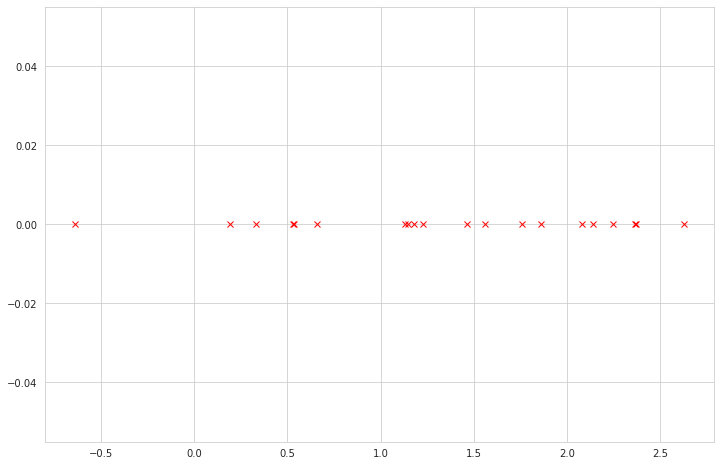

In [7]:
m = 20 # number of data points
mu_actual = 1.5 # the actual mean we will use to generate some example data points
sigma_actual = 0.75 # the actual standard deviation we will use to generate random data points

x = np.random.normal(loc=mu_actual, scale=sigma_actual, size = (m,))
plt.plot(x, np.zeros( (m,)), 'rx');

Remember that the actual mean and standard deviation we used for the points are 1.5 and 0.75 respectively.  We can get
mean likelihood estimates of the values for our randomly generated data like this:

In [8]:
mu_estimate = np.sum(x) / m
variance_estimate = np.sum( (x - mu_estimate)**2.0 ) / m
sigma_estimate = np.sqrt(variance_estimate)
print(mu_estimate, sigma_estimate, variance_estimate)

1.3382921172106135 0.8480846198163837 0.7192475223691002


In [9]:
# the .mean(), .std() and .var() functions of numpy arrays calculate the same thing 
print(x.mean(), x.std(), x.var())

1.3382921172106135 0.8480846198163837 0.7192475223691002


# Video W9 03: Anomaly Detection Algorithm

[YouTube Video Link](https://www.youtube.com/watch?v=egIWLtZjHoo&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=91)

## Density Estimation ##

One way to estimate the probability of a given observation being an anomaly or not is to make an independence assumption on
each of the $n$ features, and calculate the probability of getting each feature given our observed data.  To do this, we
use the previous method and assume that each of our features is normally distributed, and use a maximum likelihood estimate
to determine the mean and variance parameters for each of our features independently.  Given these estimations, we can use them
to calculate the probability of each observed feature, and multiplying all of these probabilities together (which works
because of the assumption of independence) gives us an overall estimate of the probability of seeing the new observation.

The final probability (or density) estimate can be stated compactly using the product formula

$$
\prod_{j=1}^n p(x_j; \mu_j, \sigma_j^2) = p(x_1; \mu_1, \sigma_1^2) \times p(x_2; \mu_2, \sigma_2^2) \times \ldots \times p(x_n; \mu_n, \sigma_n^2)
$$

Where for each of our $n$ features, we have determined the maximum likelihood $\mu_j, \sigma_j^2$ mean and variance
parameters.  The $\prod$ symbol simply means we are multiplying each of the $n$ probabilities together.

## Anomaly Detection Algorithm ##

Putting these previous concepts together, we can build an anomaly detection system using the following algorithm:

1. Choose features $x_i$ that you think might be indicative of anomalous examples.
2. Fit parameters $\mu_1, \ldots, \mu_n, \sigma_1^2, \ldots, \sigma_n^2$
$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)} \\
\sigma_j^2 = \frac{1}{m} \sum_{i=1}^{m} (x_j^{(i)} - \mu_j)^2 
$$
3. Given a new example $x$, compute $p(x)$:
$$
p(x) = \prod_{j=1}^n p(x_j; \mu_j, \sigma_j^2) = \prod_{j=1}^{n} \frac{1}{\sqrt{2 \pi} \sigma_j} \textrm{exp}(- \frac{(x_j - \mu_j)^2}{2 \sigma_j^2})
$$

And finally, we will determine a new observation is an anomaly if the probability is below some threshold, 
e.g. if $p(x) < \epsilon$.

Lets give an example in Python similar to the one shown in our video.  Lets again generate a set of data, but with
2 dimensions or features in this case.  As shown in the video, the mean and standard deviation we will use for our two
features will be:
$$
\mu_1 = 5, \sigma_1 = 2\\
\mu_2 = 3, \sigma_2 = 1
$$

Here we will show vectorized versions of computing the maximum likelihood estimates and probabilities:

In [10]:
m, n = 20, 2 # number of example data points ; number of features/dimensions
mu_actual = np.array([5.0, 3.0])
sigma_actual = np.array([2.0, 1.0])

# we will generate a mxn array of values with mean 0 and std 1.0
x = np.random.normal(loc=0.0, scale=1.0, size=(m, n))

# and we will scale each dimension to have the desired mean/std.
x[:,0] = (x[:,0] * sigma_actual[0]) + mu_actual[0]
x[:,1] = (x[:,1] * sigma_actual[1]) + mu_actual[1]

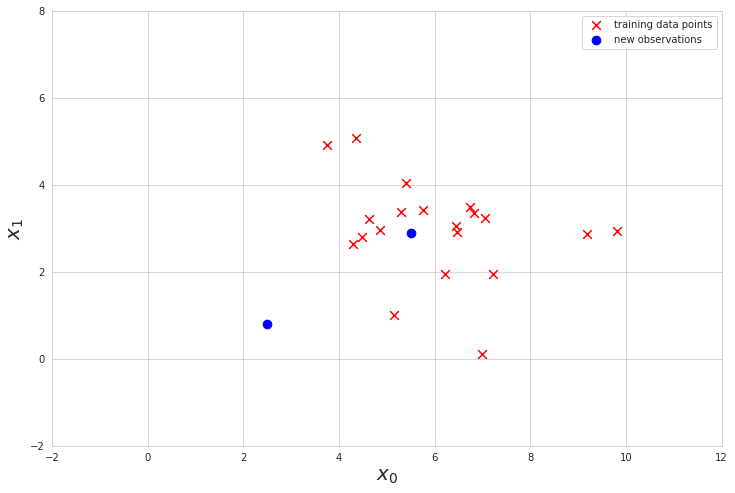

In [11]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()

In [12]:
# define a function that compute the probability/density of an observation
def probability_density_function(x, mu, sigma):
    """Calculate the probability of the given observation x for a normal distribution with mean mu and
    standard deviation sigma.  These are known as computing the probability density function, or pdf.
    This is equivalent to the scipy libraries stats.norm.pdf() function.
    """
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma) ) * np.exp(- (x - mu)**2.0 / (2.0 * sigma**2.0) )

In [13]:
# calculate the maximum likelihood mean and variance for each dimension
print( "The maximum likelihood mean and variance for our 2 dimensions:" )
print( np.mean(x, axis=0) )
print( np.std(x, axis=0) )
mu_estimate = np.mean(x, axis=0)
sigma_estimate = np.std(x, axis=0)

# calculate the density or probability estimate for the new observations
# first an example of the probability calculation for the point 0, for dimension 0 and 1
print( "" )
print( "A new observation that is not analomous:", x_new[0,:] )
p_0 = probability_density_function(x_new[0, 0], mu_estimate[0], sigma_estimate[0])
print( "Probability for dimension 0:", p_0 )
p_1 = probability_density_function(x_new[0, 1], mu_estimate[1], sigma_estimate[1])
print( "Probability for dimension 1:", p_1 )
print( "Product of independent probabilities:", p_0 * p_1 )

# now the same calculation for our anamolous point 1
print( "" )
print( "A new observation that IS analomous:", x_new[1,:] )
p_0 = probability_density_function(x_new[1, 0], mu_estimate[0], sigma_estimate[0])
print( "Probability for dimension 0:", p_0 )
p_1 = probability_density_function(x_new[1, 1], mu_estimate[1], sigma_estimate[1])
print( "Probability for dimension 1:", p_1 )
print( "Product of independent probabilities:", p_0 * p_1 )


The maximum likelihood mean and variance for our 2 dimensions:
[6.04844122 2.96691212]
[1.54294066 1.10933966]

A new observation that is not analomous: [5.5 2.9]
Probability for dimension 0: 0.2427309421015668
Probability for dimension 1: 0.35896781649658716
Product of independent probabilities: 0.08713259628235895

A new observation that IS analomous: [2.5 0.8]
Probability for dimension 0: 0.018367945262696094
Probability for dimension 1: 0.05337234663482837
Product of independent probabilities: 0.0009803403415301697


In [14]:
# we can get the exact same results using the pdf function from scipy, which we should normally do rather
# than implementing the function by hand as I have done above
import scipy.stats
print("")
print("A new observation that is not analomous:", x_new[0,:])
p_0 = scipy.stats.norm.pdf(x_new[0, 0], loc=mu_estimate[0], scale=sigma_estimate[0])
print("Probability for dimension 0:", p_0)
p_1 = scipy.stats.norm.pdf(x_new[0, 1], loc=mu_estimate[1], scale=sigma_estimate[1])
print("Probability for dimension 1:", p_1)
print("Product of independent probabilities:", p_0 * p_1)

# now the same calculation for our anamolous point 1
print("")
print("A new observation that IS analomous:", x_new[1,:])
p_0 = scipy.stats.norm.pdf(x_new[1, 0], loc=mu_estimate[0], scale=sigma_estimate[0])
print("Probability for dimension 0:", p_0)
p_1 = scipy.stats.norm.pdf(x_new[1, 1], loc=mu_estimate[1], scale=sigma_estimate[1])
print("Probability for dimension 1:", p_1)
print("Product of independent probabilities:", p_0 * p_1)



A new observation that is not analomous: [5.5 2.9]
Probability for dimension 0: 0.24273094210156682
Probability for dimension 1: 0.35896781649658716
Product of independent probabilities: 0.08713259628235896

A new observation that IS analomous: [2.5 0.8]
Probability for dimension 0: 0.018367945262696087
Probability for dimension 1: 0.05337234663482838
Product of independent probabilities: 0.0009803403415301693


In [15]:
# or to vectorize the above
print("probabilities of all points for each dimension:")
p = scipy.stats.norm.pdf(x_new, loc=mu_estimate, scale=sigma_estimate)
print(p)

print("")
print("The computed product of the probabilites for our points:")
p = np.prod(p, axis=1)
print(p)

probabilities of all points for each dimension:
[[0.24273094 0.35896782]
 [0.01836795 0.05337235]]

The computed product of the probabilites for our points:
[0.0871326  0.00098034]


In [16]:
# and finally, we can select an epsilon threshold, and determine which points are anomalous and which not
# using the given threshold
epsilon = 0.005
print(p < epsilon)

[False  True]


The above cells showed how we can compute the anomaly detection algoritm.  Lets visualize what an epsilon value of 0.005 means
for our given set of 20 data points.  Here we will plot what is essentially the decision boundary for our given set of
data, above which the threshold will determine points are "anamolous"

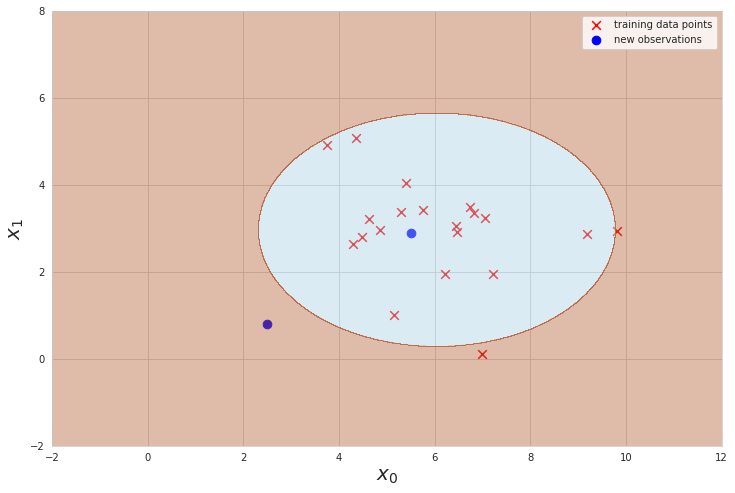

In [17]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()


# and create a mesh to detect decision boundary for a given epsilon and plot it
epsilon = 0.005
x_min, x_max = -2.0, 12.0
y_min, y_max = -2.0, 8.0
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

gridpoints = np.c_[xx.ravel(), yy.ravel()]
p = scipy.stats.norm.pdf(gridpoints, loc=mu_estimate, scale=sigma_estimate)
p = (np.prod(p, axis=1) < epsilon) * 1.0
Z = p.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4);


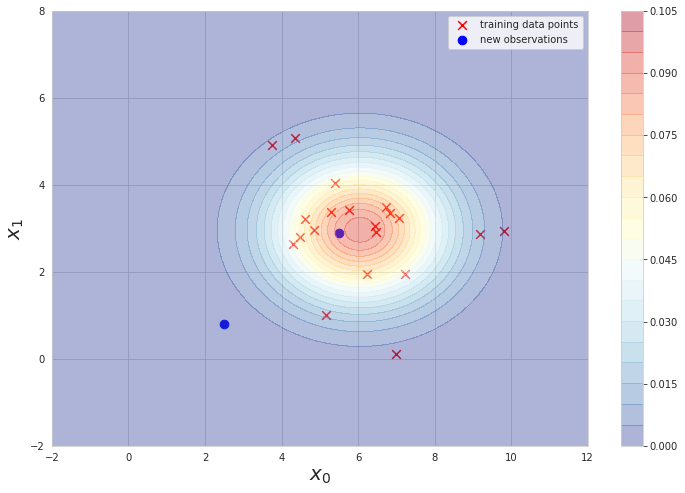

In [18]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()


# and create a mesh to detect decision boundary for a given epsilon and plot it
epsilon = 0.005
x_min, x_max = -2.0, 12.0
y_min, y_max = -2.0, 8.0
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

gridpoints = np.c_[xx.ravel(), yy.ravel()]
p = scipy.stats.norm.pdf(gridpoints, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
Z = p.reshape(xx.shape)
levels = np.arange(0.0, 0.11, 0.005)
plt.contourf(xx, yy, Z, levels, cmap=plt.cm.RdYlBu_r, alpha=0.4);
plt.colorbar();


# Video W9 04: Developing and Evaluating an Anomaly Detection System

[YouTube Video Link](https://www.youtube.com/watch?v=20dfmwVwK-8&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=92)


# Video W9 05: Anomaly Detection vs. Supervised Learning

[YouTube Video Link](https://www.youtube.com/watch?v=mGXtKNHLRMg&index=93&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


# Video W9 06: Choosing what Features to Use

[YouTube Video Link](https://www.youtube.com/watch?v=YrCQ0uRcNCk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=94)


# Video W9 07: Multivariate Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=fr5wML3y1Xk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=95)


# Video W9 08: Anomaly Detection using Multivariate Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=EobKYbaJAHM&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=96)
